# Problem
We have a partial differential equation for heat flow:
$
\frac{du}{dx} = 2 \frac{du}{dt}+u
$

Initial condition: $u(x,0) = 6\exp(-3x)$
* Independent variables: x, t (input variables)
* Dependent variables: u (output)

Analytical solution of the problem is 
$
u(x,t)=6\exp(-3x-2t)
$

In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np

In [3]:
# rewrite in layer 
class HeatNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(HeatNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, x,t):
        inputs = torch.cat([x,t], axis = 1)
        out = self.layers(inputs)
        return out

Differential model for partial differential equation:
* predict the out based on coordinates x and t
* using autograd calculate first derivatives of model $u_x$ and $u_t$
* output the differential equation constraint

We now describe the initial conditions, first pick uniformly x coordinates. Time coordinate is by definition zero and calculate the value of function at start.

In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # build model
        self.model = HeatNet(
               input_size=2,
               hidden_size=20,
               output_size=1,
               depth=2,
               act=torch.nn.Tanh).to(device)
    
        # boundary conditions
        x_bc = np.random.uniform(low=0.,high=2., size=(500,1))
        t_bc = np.zeros((500,1))
        u_bc = 6*np.exp(-3*x_bc)
    
        self.pt_x_bc = torch.from_numpy(x_bc).float().to(device)
        self.pt_x_bc.requires_grad=False
        self.pt_t_bc = torch.from_numpy(t_bc).float().to(device)
        self.pt_t_bc.requires_grad=False
        self.pt_u_bc = torch.from_numpy(u_bc).float().to(device)
        self.pt_u_bc.requires_grad=False
    
        x_points = np.random.uniform(low=0.0,high=2.0,size=(500,1))
        t_points = np.random.uniform(low=0.0,high=1.0,size=(500,1))
        all_zeros = np.zeros((500,1))
    
        self.x_input = Variable(torch.from_numpy(x_points).float(),requires_grad=True).to(device)
        self.t_input = Variable(torch.from_numpy(t_points).float(),requires_grad=True).to(device)
        self.zero_input = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
        self.mse_cost_function = torch.nn.MSELoss()
        self.iter = 1
        #self.optimizer = torch.optim.LBFGS(model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
        #                          history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def f(self, x,t):
        u = self.model(x,t) 
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        return u_x - 2*u_t - u   
    
    def loss_func(self):
        self.optimizer.zero_grad()
    
        out = self.model(self.pt_x_bc, self.pt_t_bc)
        mse_u = self.mse_cost_function(out, self.pt_u_bc)
    
        out = self.f(self.x_input, self.t_input)
        mse_f = self.mse_cost_function(out, self.zero_input)
    
        loss = mse_u + mse_f
        loss.backward()
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
    
    def train(self,epochs):
        for epoch in range(epochs):
            self.optimizer.step(self.loss_func)


In [5]:
net = Net()
net.train(1000)

 Iter: 100, loss:0.9364147186279297
 Iter: 200, loss:0.2602830231189728
 Iter: 300, loss:0.04990287870168686
 Iter: 400, loss:0.01735803484916687
 Iter: 500, loss:0.00810198299586773
 Iter: 600, loss:0.004472919274121523
 Iter: 700, loss:0.0028026991058140993
 Iter: 800, loss:0.00194842298515141
 Iter: 900, loss:0.0014581142459064722
 Iter: 1000, loss:0.0011420336086302996


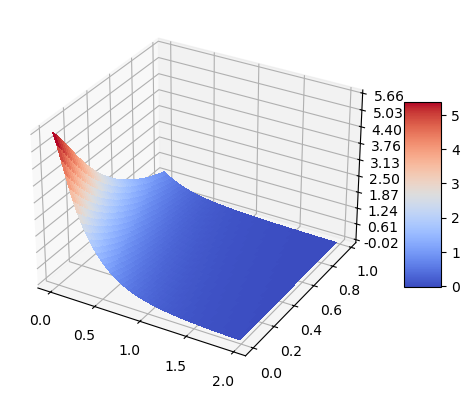

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
t = np.arange(0,1,.02)
xm, tm = np.meshgrid(x,t)

x = np.ravel(xm).reshape(-1,1)
t = np.ravel(tm).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
t_input = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

u_pred = net.model(x_input, t_input)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, tm, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()


In [7]:
def sol(x,t):
    return 6*np.exp(-3*x-2*t)
    
anal_sol = sol(x,t)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)
print(f"Mean square error between analytical and ML solution: {mse}")

Mean square error between analytical and ML solution: 0.0002064904970208744
